In [1]:
import networkx as nx
import numpy as np

In [2]:
def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v


def make_ring_lattice(n, k):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

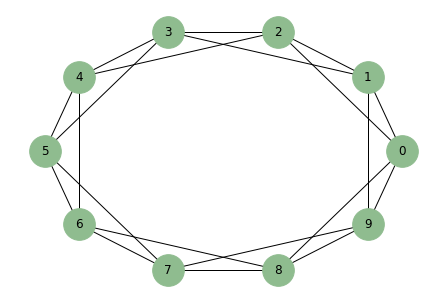

In [4]:
lattice = make_ring_lattice(10, 4)

nx.draw_circular(lattice,
                    node_color='darkseagreen',
                    node_size=1000,
                    with_labels=True)

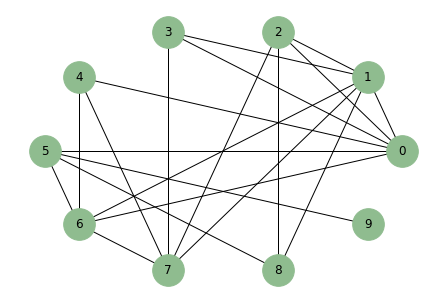

In [160]:
def flip(p):
    return np.random.random() < p


def all_pairs(nodes):
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i>j:
                yield u,v


def rewire(G:nx.Graph, p):
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)


lattice = make_ring_lattice(10, 4)
rewire(lattice, 1)
nx.draw_circular(lattice,
                    node_color='darkseagreen',
                    node_size=1000,
                    with_labels=True)
                

In [151]:
def node_clustering(G:nx.Graph, u):
    neighbors = G[u]
    k = len(neighbors)
    if k<2:
        return np.nan
    
    possible = k * (k-1)/2
    exist = 0
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist += 1
    return exist/possible


def clustering_coefficient(G):
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

lattice = make_ring_lattice(10, 4)
rewire(lattice, 1)
clustering_coefficient(lattice)

0.36296296296296293

In [183]:
n = nx.shortest_path_length(lattice)

for i in n:
    print(i)

(0, {0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 3: 2, 4: 2, 6: 2, 7: 2, 5: 3})
(1, {1: 0, 0: 1, 9: 1, 2: 1, 3: 1, 4: 2, 5: 2, 7: 2, 8: 2, 6: 3})
(2, {2: 0, 0: 1, 1: 1, 3: 1, 4: 1, 5: 2, 6: 2, 8: 2, 9: 2, 7: 3})
(3, {3: 0, 1: 1, 2: 1, 4: 1, 5: 1, 0: 2, 6: 2, 7: 2, 9: 2, 8: 3})
(4, {4: 0, 2: 1, 3: 1, 5: 1, 6: 1, 0: 2, 1: 2, 7: 2, 8: 2, 9: 3})
(5, {5: 0, 3: 1, 4: 1, 6: 1, 7: 1, 1: 2, 2: 2, 8: 2, 9: 2, 0: 3})
(6, {6: 0, 8: 1, 4: 1, 5: 1, 7: 1, 0: 2, 2: 2, 3: 2, 9: 2, 1: 3})
(7, {7: 0, 8: 1, 9: 1, 5: 1, 6: 1, 0: 2, 1: 2, 3: 2, 4: 2, 2: 3})
(8, {8: 0, 0: 1, 9: 1, 6: 1, 7: 1, 1: 2, 2: 2, 4: 2, 5: 2, 3: 3})
(9, {9: 0, 8: 1, 0: 1, 1: 1, 7: 1, 2: 2, 3: 2, 5: 2, 6: 2, 4: 3})


In [184]:
def path_lengths(G):
    length_map = nx.shortest_path_length(G)
    lengths = [length[u][v] for u, v in all_pairs(G) for length in length_map]
    return lengths
    

def characteristic_path_length(G):
    return np.mean(path_lengths(G))

lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.5

In [185]:
path_lengths(lattice)

[0, 1, 1, 2, 2, 3, 2, 2, 1, 1]